# Chapter 5: Paint

## Neural Style Transfer

_Neural style transfer_ is the practice of taking a pair of images, a _base image_ and a _style image_, and transferring the "style" of the latter image to the former in a _combined image_. For example, the base image could be a photograph and the style image could be a painting the style of which we want to copy.

We do this by minimizing a loss function with 3 parts:

1. _Content loss_, does the combined image have the same content as the base image?

2. _Style loss_, does the combined image have the same style as the style image?

3. _Total variance loss_, does the combined image appear smooth instead of pixelated?

Unlike previous models, which used gradient descent to minimize loss by backpropagating the error using a training set, we will be using a pre-trained VGG19 network, a convolutional neural network trained to classify over a million images with a thousand different labels.

## Content Loss

We do not want to use MSE between the base and combined images, since the pixel values between them may be very different. Instead, we want to measure the MSE between the output of the higher level convolutional layers of VGG19 using the base and combined images as input.

## Style Loss

In order to determine if two images have the same style, we should look at how correlated the low level features the model finds in each image. We define the _Gram matrix_, $\mathbf{G}_\ell$, as a matrix whose elements are the dot products between all possible pairs of features in the layer $\ell$. For a style image, $\mathbf{X}$, and the generated image, $\mathbf{Y}$, for a given layer of size, $m_\ell$, (height multiplied by width) with $n_\ell$ channels, the style loss is given by

$$ L_\mathbf{G}\big(\mathbf{X}, \mathbf{Y}, \ell \big) = \frac{1}{\left( 2n_\ell m_\ell \right)^2} \sum\limits_{ij} \left\{ \mathbf{G}_\ell(\mathbf{X})_{ij} - \mathbf{G}_\ell(\mathbf{Y})_{ij} \right\}^2 $$

The for several layers is the sum of the style loss for each individual layer.

## Total Variance Loss

In order to compute the total variance loss, or how noisy the image is, we simply translate the image one pixel to the right and compute the MSE between the original image and the translated image.

## Implementation

Below is an implementation of neural style transfer based on the [neural style transfer script in the Keras GitHub repository](https://github.com/keras-team/keras/blob/master/examples/neural_style_transfer.py).

In [0]:
# Mounting Google Drive to load and save images.

from google.colab import drive

drive.mount('/content/gdrive/')
base_dir = '/content/gdrive/My Drive/gdl_models/style_transfer/'

In [0]:
%tensorflow_version 1.x
from tensorflow.keras.preprocessing.image import (load_img, img_to_array,
                                                  save_img)
import numpy as np
from tensorflow.keras.applications import vgg19
import tensorflow.keras.backend as K
import time
from scipy.optimize import fmin_l_bfgs_b


IMAGE_N_ROWS = 400


def preprocess_image(img_path, shape):
  """Load an image and preprocess it for VGG19."""
  img = load_img(img_path, target_size=shape)
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  return vgg19.preprocess_input(img)


def deprocess_image(x, shape):
  """Deprocess an image from VGG19."""
  if K.image_data_format() == 'channels_first':
    x = x.reshape((3,) + shape)
    x = x.transpose((1, 2, 0))
  else:
    x = x.reshape(shape + (3,))
  # Remove zero-center by mean pixel
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:,:,::-1]
  # BGR -> RGB
  return np.clip(x, 0, 255).astype('uint8')


def content_loss(base_img, combined_img):
  """Compute the content loss."""
  return K.sum(K.square(combined_img - base_img))


def gram_matrix(x):
  """Build the Gram matrix using an output vector."""
  assert K.ndim(x) == 3
  if K.image_data_format() == 'channels_first':
    features = K.batch_flatten(x)
  else:
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
  return K.dot(features, K.transpose(features))


def style_loss(style_img, combined_img, size):
  """Compute the style loss."""
  assert K.ndim(style_img) == 3
  assert K.ndim(combined_img) == 3
  S = gram_matrix(style_img)
  C = gram_matrix(combined_img)
  channels = 3
  h, w = size
  return K.sum(K.square(S - C)) / ((2.0 * channels * h * w) ** 2)


def total_variance_loss(x, size):
  """Compute the total variance loss."""
  assert K.ndim(x) == 4
  h, w = size
  # a: translation 1 pixel down, b: translation 1 pixel to the right
  if K.image_data_format() == 'channels_first':
    a = K.square(x[:, :, :h - 1, :w - 1] - x[:, :, 1:, :w - 1])
    b = K.square(x[:, :, :h - 1, :w - 1] - x[:, :, :h - 1:, 1:])
  else:
    a = K.square(x[:, :h - 1, :w - 1, :] - x[:, 1:, :w - 1, :])
    b = K.square(x[:, :h - 1, :w - 1, :] - x[:, :h - 1:, 1:, :])
  return K.sum(K.pow(a + b, 1.25))


def eval_loss_and_gradients(x, size, f_outputs):
  """Compute the loss and loss gradients."""
  if K.image_data_format() == 'channels_first':
    x = x.reshape((1, 3) + size)
  else:
    x = x.reshape((1,) + size + (3,))
  outs = f_outputs([x])
  loss_value = outs[0]
  if len(outs[1:]) == 1:
    grad_values = outs[1].flatten().astype('float64')
  else:
    grad_values = np.array(outs[1:]).flatten().astype('float64')
  return loss_value, grad_values


class Evaluator(object):
  """Evaluator class is used by the optimizer."""

  def __init__(self):
    self.loss_value = None
    self.grad_values = None

  def loss(self, x, size, f_outputs):
    """Set the loss' and gradients' values."""
    assert self.loss_value is None
    loss_value, grad_values = eval_loss_and_gradients(x, size, f_outputs)
    self.loss_value = loss_value
    self.grad_values = grad_values
    return self.loss_value

  def grads(self, x):
    """Return the gradient value and reset internal state."""
    assert self.loss_value is not None
    grad_values = np.copy(self.grad_values)
    self.loss_value = None
    self.grad_values = None
    return grad_values


def neural_style_transfer(base_image_path, style_image_path,
                          combined_image_path, iterations,
                          lambda_content=0.025, lambda_style=1,
                          lambda_total_variance=1):
  """Apply neural style transfer."""
  w, h = load_img(base_image_path).size
  img_n_cols = IMAGE_N_ROWS * w // h
  size = (IMAGE_N_ROWS, img_n_cols)

  base_img = K.variable(preprocess_image(base_image_path, size))
  style_img = K.variable(preprocess_image(style_image_path, size))

  if K.image_data_format() == 'channels_first':
    combined_img = K.placeholder((1, 3) + size)
  else:
    combined_img = K.placeholder((1,) + size + (3,))
  
  input_tensor = K.concatenate([base_img, style_img, combined_img], axis=0)
  model = vgg19.VGG19(input_tensor=input_tensor, weights='imagenet',
                      include_top=False)
  
  outputs_dict = {layer.name: layer.output for layer in model.layers}

  loss = K.variable(0.0)

  layer_features = outputs_dict['block5_conv2']
  base_img_features = layer_features[0, :, :, :]
  combined_img_features = layer_features[2, :, :, :]
  loss = loss + lambda_content * content_loss(base_img_features,
                                              combined_img_features)
  
  n_feature_layers = 5
  for layer_name in ['block{}_conv1'.format(i)
                     for i in range(1, n_feature_layers + 1)]:
    layer_features = outputs_dict[layer_name]
    style_img_features = layer_features[1, :, :, :]
    combined_img_features = layer_features[2, :, :, :]
    sl = style_loss(style_img_features, combined_img_features, size)
    loss = loss + (lambda_style / n_feature_layers) * sl

  loss = loss + lambda_total_variance * total_variance_loss(combined_img, size)
  
  grads = K.gradients(loss, combined_img)
  outputs = [loss]
  if isinstance(grads, (list, tuple)):
    outputs += grads
  else:
    outputs.append(grads)

  f_outputs = K.function([combined_img], outputs)
  evaluator = Evaluator()
  x = preprocess_image(base_image_path, size)

  for i in range(iterations):
    print('Starting iteration', i)
    start_time = time.time()
    evaluate_loss = lambda x: evaluator.loss(x, size, f_outputs)
    x, min_val, info = fmin_l_bfgs_b(evaluate_loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    if i % 10 == 0:
      img = deprocess_image(x.copy(), size)
      save_img(combined_image_path, img)
      print('Image saved')
    end_time = time.time()
    print('Iteration {} completed in {}s'.format(i, end_time - start_time))

TensorFlow 1.x selected.


In [0]:
base_image_path = base_dir + 'base_image.png'
style_image_path = base_dir + 'style_image.png'
combined_image_path = base_dir + 'combined_image.png'
iterations = 1000

neural_style_transfer(base_image_path, style_image_path, combined_image_path,
                      iterations, lambda_content=0.000025, lambda_style=100,
                      lambda_total_variance=0.5)

## Displaying the Results

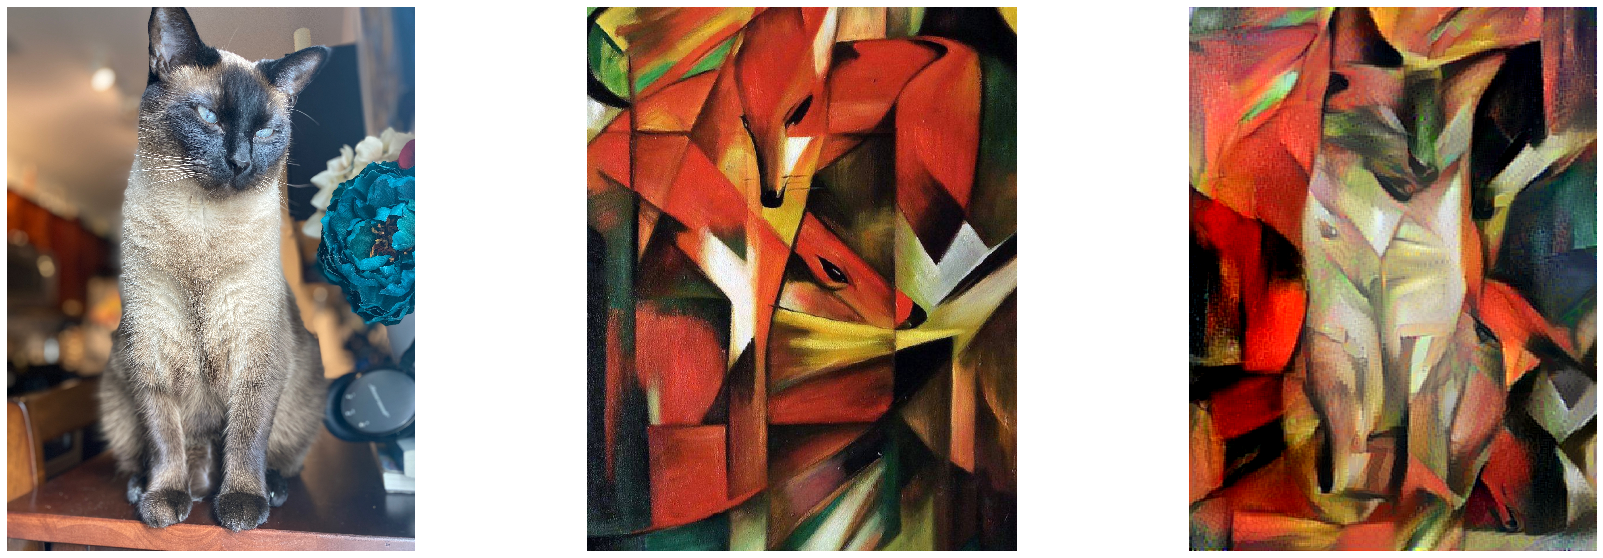

In [31]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30, 10))

ax = fig.add_subplot(1, 3, 1)
ax.axis('off')
ax.imshow(img_to_array(load_img(base_dir + 'base_image.png')) / 255.0,
          interpolation='nearest')

ax = fig.add_subplot(1, 3, 2)
ax.axis('off')
ax.imshow(img_to_array(load_img(base_dir + 'style_image.png')) / 255.0,
          interpolation='nearest')

ax = fig.add_subplot(1, 3, 3)
ax.axis('off')
ax.imshow(img_to_array(load_img(base_dir + 'combined_image.png')) / 255.0,
          interpolation='nearest')